In [56]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/home/enis/projects/nna/src


In [57]:
import csv
from os import listdir
from pathlib import Path

# LOAD LABELS by human
labelsbyhumanpath=Path('/scratch/enis/data/nna/labeling/results/')
# filter csv extension also by username
labelsbyhuman=[i for i in listdir(labelsbyhumanpath) if (".csv" in i ) ]

humanresults={}
counter=0
for apath in labelsbyhuman:
    with open(labelsbyhumanpath / apath, newline='') as f:
        reader=csv.reader(f)
        for row in reader:
            counter+=1
            humanresults[row[0]]=row[1:]

print("unique files:",len(humanresults),"\ntotal files",counter)

#Join vehicle and Aircraft
# for file_name,tagshere in humanresults.items():
# #     print(file_name,tagshere)
    
#     tagshere=["Aircraft" if tag == "Vehicle" else tag for tag in tags]

unique files: 1300 
total files 1366


In [58]:
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F


# fldr="/scratch/enis/data/nna/labeling/splits_preprocessed_real/"
# fname="S4A10209_20190505_093000_51m_7s__51m_17s_preprocessed.npy"

# preProcessedFile=Path(fldr)/fname


# preProcessedArray=np.load(preProcessedFile)

In [253]:
# import IPython.display as ipd
# ipd.Audio(sourcePath/file_name)

/scratch/enis/conda/envs/speechEnv/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


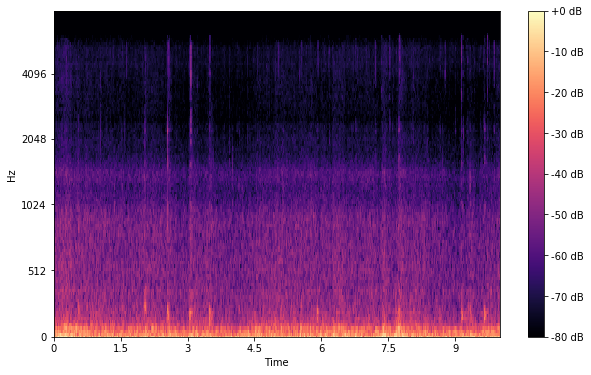

In [102]:
import matplotlib.pyplot as plt
from pydub import AudioSegment
plt.figure(figsize=(10, 6))

y, sr = librosa.load(sourcePath/file_name,sr=None)
# audio = AudioSegment.from_file(sourcePath/file_name)

mel=librosa.feature.melspectrogram(y=y+0.1, sr=sr)
an_x = librosa.power_to_db(mel, ref=np.max)

librosa.display.specshow(an_x, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')

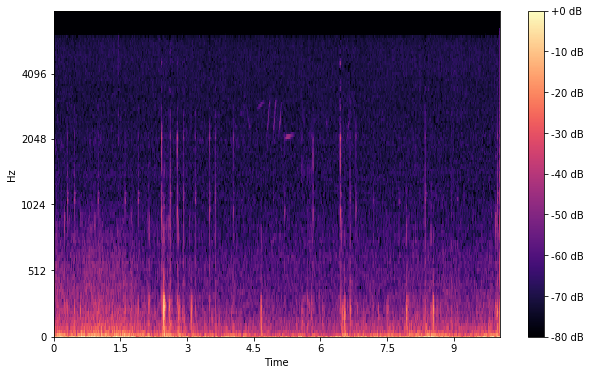

In [234]:
import matplotlib.pyplot as plt
from pydub import AudioSegment
plt.figure(figsize=(10, 6))

y, sr = librosa.load("louder_song.mp3",sr=None)
# audio = AudioSegment.from_file(sourcePath/file_name)

mel=librosa.feature.melspectrogram(y=y, sr=sr)
an_x = librosa.power_to_db(mel, ref=np.max)

librosa.display.specshow(an_x, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')

/scratch/enis/conda/envs/speechEnv/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


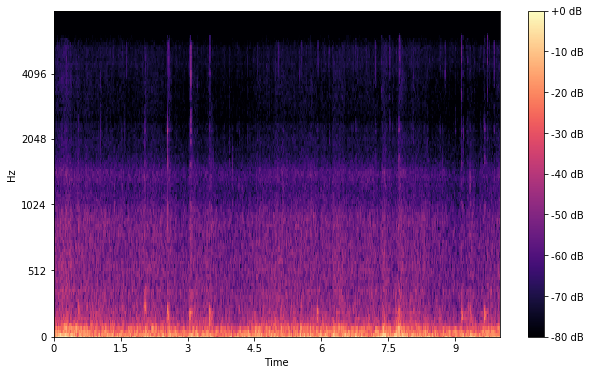

In [98]:
import matplotlib.pyplot as plt
from pydub import AudioSegment
plt.figure(figsize=(10, 6))

y, sr = librosa.load(sourcePath/file_name,sr=None)
# audio = AudioSegment.from_file(sourcePath/file_name)

mel=librosa.feature.melspectrogram(y=y, sr=sr)
an_x = librosa.power_to_db(mel, ref=np.max)

librosa.display.specshow(an_x, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000)
plt.colorbar(format='%+2.0f dB')

In [60]:
import csv 
from pathlib import Path
from os import listdir
from sklearn.model_selection import train_test_split

# import pickle

# from labeling_utils import load_labels

# import numpy as np
# from sklearn.metrics import precision_recall_fscore_support

# from sklearn.model_selection import train_test_split
# import pandas as pd

# tags=["Songbird","Water Bird","Insect","Running Water","Rain","Cable","Wind","Aircraft"]
tagSet=["Songbird","Water Bird","Insect","Running Water","Rain","Cable","Wind","Aircraft"]

# from tabulate import tabulate
# tag_set=tags[:]
# import torch

# %matplotlib inline



* Count only highest ranking tag (what if both of them exist)
* Bird tag is confusing, it can be also waterbird, how to handle ? Also Animal
* 

In [61]:
#LOAD MODEL predictions
splits_path= Path('/files/scratch/enis/data/nna/labeling/splits/')



In [62]:
# returns a dictionary, keys are tags from tag set and values are binary list 
# 
def vectorized_y_true(humanresults,tag_set):
    y_true={tag: np.zeros(len(humanresults)) for tag in tag_set}
    for i,tags in enumerate(humanresults.values()):
        # we  only look for tags in tag_set
        for tag in tag_set:
            if tag in tags:
                y_true[tag][i] = 1
            else:
                y_true[tag][i] = 0 
    return y_true



In [63]:
y_true_dict = vectorized_y_true(humanresults,tagSet)
y_true_all = pd.DataFrame(y_true_dict)
y_true = np.array(y_true_all['Water Bird']).astype("long")


In [64]:
def map_reduce(X,func_type):
    if func_type=="Average":
        return np.mean(X,axis=1)
    elif func_type=="Concat":
        return np.reshape(X,(-1,1280))
    else:
        raise Exception("ERROR with embed type")

def pick_embed(embed_type:str, sourcePath: Path):
    
    for index,i in enumerate(humanresults):
        file_name=Path(i).stem
        if embed_type=="Raw":
            file_name+="_rawembed.npy"
        elif embed_type=="Normalized":
            file_name+="_rawembed.npy"
        elif embed_type=="Unsupervised":
            file_name+="_superembedv2.npy"
        elif embed_type=="LogMel":
            file_name+="_preprocessed.npy"

        else:
            raise Exception("ERROR with embed type")
        an_x=np.load(sourcePath / file_name)
        if index==0:
            X= np.empty((len(humanresults),*an_x.shape))
        X[index,:,:]=an_x[:]
    return X

In [65]:

sourcePath=Path('/scratch/enis/data/nna/labeling/split_embeddings/')
sourcePath=Path("/scratch/enis/data/nna/labeling/splits_preprocessed/")
# filter by username
# split_embeds=[i for i in listdir(sourcePath) ]
# raw_embeds =  [i for i in split_embeds if "rawembed" in i]
# proc_embeds = [i for i in split_embeds if "_embed" in i]
# super_embed = [i for i in split_embeds if "_superembedv2" in i]


In [103]:
import warnings
warnings.filterwarnings('ignore')

In [256]:
for index,i in enumerate(humanresults):
    file_name=Path(i)
    audio = AudioSegment.from_file(sourcePath/file_name)
    audio=audio+10
    f=audio.export("./louder/"/file_name)

In [257]:
import librosa
import librosa.display
import numpy as np
from pathlib import Path

sourcePath=Path("/scratch/enis/data/nna/labeling/splits/")
sourcePath=Path("./louder/")

    
for index,i in enumerate(humanresults):
    file_name=Path(i)
    y, sr = librosa.load(sourcePath/file_name,sr=None)
    mel=librosa.feature.melspectrogram(y=y, sr=sr)
    an_x = librosa.power_to_db(mel, ref=np.max)
    
    if index==0:
        XLouder= np.empty((len(humanresults),128,850))
    XLouder[index,:,:]=an_x[:,:850]
    if index%100==0:
        print(i)




NIGLIQ2_20160702_002037_1368m_33s__1368m_43s.mp3
CLVL4_20160606_191142_0030m_19s__0030m_29s.mp3
NIGLIQ2_20160706_034307_2362m_50s__2363m_00s.mp3
UMIAT_20130719_230628_0807m_10s__0807m_20s.mp3
CLVL5_20160615_024034_2490m_44s__2490m_54s.mp3
FSHCK4_20160701_213049_0192m_33s__0192m_43s.mp3
ITKILLIK1_20160813_032044_2145m_41s__2145m_51s.mp3
ITKILLIK2_20160723_151926_0015m_11s__0015m_21s.mp3
CLVL4_20160703_020906_2243m_55s__2244m_05s.mp3
ITKILLIK1_20160729_153220_1242m_45s__1242m_55s.mp3
CLVL5_20160707_045736_1015m_27s__1015m_37s.mp3
SHORTY_20160619_042858_0918m_46s__0918m_56s.mp3
ITKILLIK1_20160727_135107_1960m_05s__1960m_15s.mp3


In [79]:
sourcePath / "ITKILLIK1_20160823_114644_0000m_00s__0000m_10s.mp3"

PosixPath('/scratch/enis/data/nna/labeling/splits/ITKILLIK1_20160823_114644_0000m_00s__0000m_10s.mp3')

In [10]:
X=pick_embed("LogMel",sourcePath)
# X=pick_embed("Unsupervised")
# Unsupervised
# X=map_reduce(X,map_reduce_type)
humanresults_keys=list(humanresults.keys())
X=X.astype("float32")

In [110]:
X=X.astype("float32")

In [258]:
XLouder=XLouder.astype("float32")

In [111]:
# from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
# def cal_metrics(y_true_dict,y_pred_dict):
#     results={}
#     for tag in tag_set:
#         y_true = y_true_dict[tag]
#         y_pred = y_pred_dict[tag]
#         metrics=precision_recall_fscore_support(y_true, y_pred,pos_label=1,average="binary")
#         results[tag]=(metrics)
#     return results

# def cal_auc(y_true_dict,y_pred_dict_prob):
#     results={}
#     for tag in tag_set:
#         y_true = y_true_dict[tag]
#         y_pred = y_pred_dict_prob[tag]
#         metrics_auc=roc_auc_score(y_true, y_pred) #average_precision_score
#         results[tag]=(metrics_auc)

#     return results

# def print_results(results,y_true_dict,):
#     headers= ["Label","Positive","Precision","Recall","Fscore"]
#     table=[]
#     sample_count=len(next(iter(y_true_dict.values())))
#     print("Total sample:",sample_count,"And threshold is",prob_threshold)
#     for tag in (tag_set):
#         positive_count=sum(y_true_dict[tag])
#         table.append([tag,positive_count,*results[tag][:-1]])

#     print(tabulate(table, headers=headers))

    

In [112]:
def nogradloss(X_test,y_test):
    with torch.no_grad():    
        outputs_test = net(X_test)
        loss = criterion(outputs_test, y_test)
        return loss.item()

def nogradmetrics(X_test,y_test,net,multi_segment=False):
    with torch.no_grad():    
        if not multi_segment:
            y_pred = net(X_test)
#             print(y_pred.shape)
#             print(y_pred[1:5,:])
    #         print(y_pred)
            loss = criterion(y_pred, y_test)
    #         print(y_pred)
            y_pred=torch.exp(y_pred)
#             print(sum(torch.max(y_pred, 1)[1]))
#             _, predicted = torch.min(y_pred,1)
#             print(np.exp(_.cpu().numpy()),predicted)
#                     print(y_test.shape,y_pred.shape)
            train_auc=roc_auc_score(y_test.cpu().numpy(),
                                    y_pred[:,1].cpu().numpy()) 
            
            return loss.item(),train_auc
        else:
            y_pred = net(X_test)
            
            y_pred_10 =y_pred.reshape(-1,10,2)
            indices=torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices
            y_pred_10 = y_pred_10[range(y_pred_10.shape[0]),indices,:].reshape(-1,2)
            
            y_test_10 = torch.max(y_test.reshape(-1,10),dim=1).values
            
            loss = criterion(y_pred_10, y_test_10)
            train_auc=roc_auc_score(y_test_10.cpu().numpy(),
                                    y_pred_10[:,1].cpu().numpy()) 
            return loss.item(),train_auc

        
class audioDataset(Dataset):

    def __init__(self,X,y, transform=None):
        """
        Args:

        """
        self.X=X
        self.y=y
#         self.landmarks_frame = pd.read_csv(csv_file)
#         self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):

        sample = self.X[idx],self.y[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [113]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device="cpu"

In [14]:
# def augment_data(data,augmentad_size):
#     if data.shape[0]>=augmentad_size:
#         return data[:]
    
#     # Augment post samples
#     augmentad = data[:]
#     while augmentad.shape[0] < augmentad_size:
#         left=augmentad_size-augmentad.shape[0]
#         left= augmentad.shape[0] if left>augmentad.shape[0] else left
# #         left = 2 if left==1 else left 
# #         print(augmentad.shape[0],left)
#         new=np.empty((left,augmentad.shape[1],augmentad.shape[2]))
# #         print(torch.randperm(augmentad.shape[0])[:left])
#         first,second=augmentad[torch.randperm(augmentad.shape[0])[:left],:,:].reshape(-1,10,128),augmentad[torch.randperm(augmentad.shape[0])[:left],:,:].reshape(-1,10,128)
# #         print(first.shape,second.shape)
#         new[:,0:5,:],new[:,5:10,:]=first[:,0:5,:],second[:,5:10,:]
#         augmentad=np.concatenate([augmentad,new])
#     #     print(augmentad.shape)
#         augmentad=np.unique(augmentad,axis=0)
#     #     print(augmentad.shape)
#     return augmentad

#### Run only one of the following cells that does splitting 

In [15]:
# MEAN, AUGMENTAD entire dataset including test and validate

pos_index= (y_true==1)
neg_index= (y_true==0)


X_shuffled = X[:,torch.randperm(X.shape[1]),:]

X_shuffled_pos=X_shuffled[pos_index,:,:]
X_shuffled_neg=X_shuffled[neg_index,:,:]

augmentad_pos=augment_data(X_shuffled_pos,2000)

augmentad_neg=augment_data(X_shuffled_neg,2000)


X_augmented=np.concatenate([augmentad_pos,augmentad_neg]).astype("float32")
y_true_aug=np.concatenate([np.ones(augmentad_pos.shape[0]),np.zeros(augmentad_neg.shape[0])]).astype("int64")



MULTI_SEGMENT = False
X_augmented_mean=X_augmented.mean(axis=1)

X_train, X_test, y_train, y_test = train_test_split(
                    X_augmented_mean, y_true_aug, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
                    X_train, y_train, test_size=0.25, random_state=42)

# X_train=X_train.reshape(X_train.shape[0],-1,128)
# X_test=X_test.reshape(X_test.shape[0],-1,128)
# X_val=X_val.reshape(X_test.shape[0],-1,128)


In [16]:
# AUGMENTATION Experiment
# from "Shuffling and Mixing Data Augmentation for Environmental Sound Classification" by Tadanobu Inoue et. al

MULTI_SEGMENT = False
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

X_train=X_train.reshape(X_train.shape[0],-1,128)
X_test=X_test.reshape(X_test.shape[0],-1,128)
X_val=X_val.reshape(X_test.shape[0],-1,128)



pos_index= (y_train==1)
neg_index= (y_train==0)

# shuffle each sample sound within itself, granularity is 1 second, samples are 10 second
# so change order of seconds
X_shuffled = X_train[:,torch.randperm(X_train.shape[1]),:]
# no shuffle
# X_shuffled = X_train[:,:,:]

X_shuffled_pos=X_shuffled[pos_index,:,:]
X_shuffled_neg=X_shuffled[neg_index,:,:]

augmentation_ratio=1.2
augmentation_ratio=(1/augmentation_ratio)
augmentad_pos=augment_data(X_shuffled_pos,int(X_shuffled_pos.shape[0]//augmentation_ratio))
# augmentad_neg=augment_data(X_shuffled_neg,int(X_shuffled_neg.shape[0]//augmentation_ratio))
augmentad_neg=augment_data(X_shuffled_neg,X_shuffled_neg.shape[0])


X_train_augmented=np.concatenate([augmentad_pos,augmentad_neg]).astype("float32")
y_train_aug=np.concatenate([np.ones(augmentad_pos.shape[0]),np.zeros(augmentad_neg.shape[0])]).astype("int64")

X_train=X_train_augmented[:]
y_train=y_train_aug[:]

X_train=X_train.mean(axis=1)
X_test=X_test.mean(axis=1)
X_val=X_val.mean(axis=1)


In [17]:
# concat inputs
MULTI_SEGMENT = False
FLAT=True
X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

X_train=X_train.reshape(X_train.shape[0],-1,128)
X_test=X_test.reshape(X_test.shape[0],-1,128)
X_val=X_val.reshape(X_test.shape[0],-1,128)


(1300, 10, 96, 64)

In [516]:
# MEAN
MULTI_SEGMENT = False
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X_mean, y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# X_train=X_train.reshape(X_train.shape[0],-1,128)
# X_test=X_test.reshape(X_test.shape[0],-1,128)
# X_val=X_val.reshape(X_test.shape[0],-1,128)


(1300, 1280)

In [311]:
# fully forward best

# seperate,  
# different AUC calculation PART, to be fair  (do max of 10 predictions)
MULTI_SEGMENT = True
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# use 1 second as  samples
X_train=X_train.reshape(-1,np.prod(X.shape[2:]))
X_test=X_test.reshape(-1,np.prod(X.shape[2:]))
X_val=X_val.reshape(-1,np.prod(X.shape[2:]))

# repeat labels
y_train=np.repeat(y_train,10)
y_test=np.repeat(y_test,10)
y_val=np.repeat(y_val,10)




In [15]:
# LSTM 

# seperate,  
# different AUC calculation PART, to be fair  (do max of 10 predictions)
MULTI_SEGMENT = False
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],10,-1), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

# use 1 second as  samples
# X_train=X_train.reshape(-1,np.prod(X.shape[2:]))
# X_test=X_test.reshape(-1,np.prod(X.shape[2:]))
# X_val=X_val.reshape(-1,np.prod(X.shape[2:]))

# repeat labels
# y_train=np.repeat(y_train,10)
# y_test=np.repeat(y_test,10)
# y_val=np.repeat(y_val,10)




In [115]:
X.shape

(1300, 128, 850)

In [260]:
# CNN-2  

# seperate,  
# different AUC calculation PART, to be fair  (do max of 10 predictions)
MULTI_SEGMENT = False
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    XLouder.reshape(XLouder.shape[0],1,XLouder.shape[1],XLouder.shape[2]), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

## if MULTI_SEGMENT
# use 1 second as  samples
# X_train=X_train.reshape(-1,np.prod(X.shape[2:]))
# X_test=X_test.reshape(-1,np.prod(X.shape[2:]))
# X_val=X_val.reshape(-1,np.prod(X.shape[2:]))

# repeat labels
# y_train=np.repeat(y_train,10)
# y_test=np.repeat(y_test,10)
# y_val=np.repeat(y_val,10)




In [149]:
X.shape,y_true.shape

((1300, 128, 850), (1300,))

In [159]:
X2=X[:]
y_true2=y_true[:]
count=0
select=[]
for i,m in enumerate(y_true):
    if m==0 and count<300:
        count+=1
        select.append(i)
    if m==1:
        select.append(i)

X2=X2[select]
y_true2=y_true2[select]

(496, 128, 850)

In [153]:
# CNN, Multi segment

# seperate,  
# different AUC calculation PART, to be fair  (do max of 10 predictions)
MULTI_SEGMENT = True
FLAT=False

X_train, X_test, y_train, y_test = train_test_split(
    X.reshape(X.shape[0],X.shape[1],1,X.shape[2],X.shape[3]), y_true, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

## if MULTI_SEGMENT
# use 1 second as  samples
X_train=X_train.reshape(*[X_train.shape[0]*X_train.shape[1]]+list(X_train.shape[2:]))
X_test=X_test.reshape(*[X_test.shape[0]*X_test.shape[1]]+list(X_test.shape[2:]))
X_val=X_val.reshape(*[X_val.shape[0]*X_val.shape[1]]+list(X_val.shape[2:]))



# repeat labels
y_train=np.repeat(y_train,10)
y_test=np.repeat(y_test,10)
y_val=np.repeat(y_val,10)




In [117]:
X_train.shape,X.shape

((780, 1, 128, 850), (1300, 128, 850))

In [242]:

XALL=X.reshape(*[X.shape[0]*X.shape[1],1]+list(X.shape[2:]))
y_trueALL=np.repeat(y_true,10)
XALL=torch.from_numpy(XALL).to(device)
# birds

y_trueALL=torch.from_numpy(y_trueALL).to(device)

(13000, 1, 96, 64)

In [239]:
XALL.shape

torch.Size([13000, 96, 64])

In [16]:
# X_train.reshape((X_train.shape[0],96,64))
# X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2],X_train.shape[3]).shape

In [17]:
# np.concatenate(X_train[0,:,:,:],axis=0).shape

In [55]:
X.shape,X_train.shape,y_train.shape

((1300, 10, 96, 64), torch.Size([780, 1, 10, 96, 64]), torch.Size([780]))

### From here, run all cells: moving data to device, model creation and training

In [261]:
X_train=torch.from_numpy(X_train).to(device)
X_test=torch.from_numpy(X_test).to(device)
X_val=torch.from_numpy(X_val).to(device)
# birds

y_val=torch.from_numpy(y_val).to(device)
y_test=torch.from_numpy(y_test).to(device)
y_train=torch.from_numpy(y_train).to(device)


    
params = {'batch_size': 100,
          'shuffle': True,
          'num_workers': 0}

training_set=audioDataset(X_train,y_train)
training_generator = DataLoader(training_set, **params)





In [62]:
# class LSTMNet(nn.Module):

#     def __init__(self, input_size, hidden_size, tagset_size):
#         super(LSTMNet, self).__init__()
#         self.hidden_size = hidden_size

# #         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

#         # The LSTM takes word embeddings as inputs, and outputs hidden states
#         # with dimensionality hidden_dim.
#         self.lstm = nn.LSTM(input_size, hidden_size,batch_first=True,num_layers=1)

#         # The linear layer that maps from hidden state space to tag space
#         self.linearLayer= nn.Linear(10*hidden_size, 64)
#         self.linearLayer2= nn.Linear(64,64)
#         self.hidden2tag = nn.Linear(64, tagset_size)

#     def forward(self, sentence):
# #         embeds = self.word_embeddings(sentence)

# #seq_len, batch, input_size
# #(batch, seq, feature).
#         lstm_out, _ = self.lstm(sentence)
# #         print(lstm_out.shape)
#         tag_space= F.relu(self.linearLayer(lstm_out.reshape(len(sentence), -1)))
#         tag_space= F.relu(self.linearLayer2(tag_space)

#         tag_space = (self.hidden2tag(tag_space))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores
    
    
# tagset_size=2
# input_size=X_train.shape[-1]
# HIDDEN_DIM=512
# net = LSTMNet(input_size, HIDDEN_DIM, tagset_size).float().to(device)

# # net = Net().double().to(device)
# loss_values={"test":[],"train":[],"train_auc":[],"test_auc":[]}



In [76]:
# best_model.eval()
# y_pred=best_model(X_train)
# for i in range(len(y_train)):
#     print(torch.exp(y_pred[i:i+1]),y_train[i:i+1])

In [77]:
# best_model.eval()
# y_pred=best_model(X_train[0:2])

# torch.max(y_pred, 1)[1]

In [78]:
# criterion(np.array(1),np.array(1))

In [79]:
inputs.shape

torch.Size([80, 1, 960, 64])

In [96]:
torch.cuda.empty_cache()

In [112]:
# class CNN_LSTMNet(nn.Module):

#     def __init__(self, input_size, hidden_size, tagset_size,out_channels):
#         super(CNN_LSTMNet, self).__init__()
        
    
#         self.out_channels=out_channels
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3,3),padding=(1, 1))
#         self.pool = nn.MaxPool2d(2, 2)
        
        
#         self.hidden_size = hidden_size

# #         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

#         # The LSTM takes word embeddings as inputs, and outputs hidden states
#         # with dimensionality hidden_dim.
#         self.lstm = nn.LSTM(input_size, hidden_size,batch_first=True,num_layers=1)

#         # The linear layer that maps from hidden state space to tag space
#         self.linearLayer= nn.Linear(10*hidden_size, 64)
#         self.linearLayer2= nn.Linear(64,64)
#         self.hidden2tag = nn.Linear(64, tagset_size)
#         self.drop = nn.Dropout(p=0.4) #0.2
#     def forward(self, sentence):
# #         embeds = self.word_embeddings(sentence)

# #seq_len, batch, input_size
# #(batch, seq, feature).
#         xx=[]
# #         print(sentence.shape)
#         for i in range(10):
#             s=sentence[:,:,i,:,:]
#             x=self.conv1(s)
#     #         print(x.shape)
#             x=self.pool(x)
#     #         print(x.shape)

#             x=self.drop(x)
#             xx.append(x)
# #             print(x.shape)
#         sentence=torch.cat(xx,axis=1)
#         shapeS=sentence.shape
# #         print(shapeS)
#         shapeNew=shapeS[0],10,np.prod([ self.out_channels,*shapeS[2:]])
#         sentence=sentence.view(shapeNew)
# #         print(sentence.shape)
#         lstm_out, _ = self.lstm(sentence)
# #         print(lstm_out.shape)
#         tag_space= F.relu(self.linearLayer(lstm_out.reshape(len(sentence), -1)))
#         tag_space= F.relu(self.linearLayer2(tag_space))
#         tag_space = (self.hidden2tag(tag_space))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores
    
# out_channels=2
# tagset_size=2
# input_size=3072
# HIDDEN_DIM=16
# net = CNN_LSTMNet(input_size, HIDDEN_DIM, tagset_size,out_channels).float().to(device)

# # net = Net().double().to(device)
# loss_values={"test":[],"train":[],"train_auc":[],"test_auc":[]}



In [119]:
"""
Utility function for computing output of convolutions
takes a tuple of (h,w) and returns a tuple of (h,w)
"""
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

In [120]:
49//2

24

In [266]:


class Net(nn.Module):
    def __init__(self,out_channels,out_channels2,h_w,kernel_size,kernel_size2):
        super(Net, self).__init__()
        self.out_channels=out_channels
        self.out_channels2=out_channels2
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=kernel_size,padding=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1_h,self.conv1_w = conv_output_shape(h_w, kernel_size=kernel_size, pad=1)
        self.conv1_h,self.conv1_w=self.conv1_h//2,self.conv1_w//2
        
        self.conv2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels2, kernel_size=kernel_size2,padding=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_h,self.conv2_w = conv_output_shape([self.conv1_h,self.conv1_w], kernel_size=kernel_size2, pad=1)
        self.conv2_h,self.conv2_w=self.conv2_h//2,self.conv2_w//2
        
#         print(self.conv1_h,self.conv1_w)
# #         self.conv2 = nn.Conv2d(6, 16, 5)
        if FLAT:
            self.fc1 = nn.Linear(1280, 10) #100
        else:
            self.fc1 = nn.Linear(self.out_channels2*self.conv2_h*self.conv2_w, 10) #100
#         self.fc1 = nn.Linear(128, 32)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc1_bn = nn.BatchNorm1d(10) # 100

        self.fc2 = nn.Linear(10, 10) # 32
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc2_bn = nn.BatchNorm1d(10)

        self.fc3 = nn.Linear(10,10)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        self.fc3_bn = nn.BatchNorm1d(5)

        self.fc4 = nn.Linear(10, 2) #100
        torch.nn.init.xavier_normal_(self.fc4.weight)

        self.drop = nn.Dropout(p=0.4) #0.2
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x=self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x=self.drop(x)

        x = x.view(-1, self.out_channels2*self.conv2_h*self.conv2_w)

        x = F.relu(self.fc1_bn(self.fc1(x)))
        x=self.drop(x)

        x = self.fc4(x)
        x = F.log_softmax(x,dim=1)
        return x

h_w=[128,850]
kernel_size=(3,3)
net = Net(2,2,h_w,kernel_size,kernel_size).float().to(device)
loss_values={"test":[],"train":[],"train_auc":[],"test_auc":[]}



In [281]:


class Net(nn.Module):
    def __init__(self,out_channels,h_w,kernel_size):
        super(Net, self).__init__()
        self.out_channels=out_channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=kernel_size,padding=(1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1_h,self.conv1_w = conv_output_shape(h_w, kernel_size=kernel_size, pad=1)
        self.conv1_h,self.conv1_w=self.conv1_h//2,self.conv1_w//2
#         print(self.conv1_h,self.conv1_w)
# #         self.conv2 = nn.Conv2d(6, 16, 5)
        if FLAT:
            self.fc1 = nn.Linear(1280, 10) #100
        else:
            self.fc1 = nn.Linear(self.out_channels*self.conv1_h*self.conv1_w, 10) #100
#         self.fc1 = nn.Linear(128, 32)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc1_bn = nn.BatchNorm1d(10) # 100

        self.fc2 = nn.Linear(10, 10) # 32
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc2_bn = nn.BatchNorm1d(10)

        self.fc3 = nn.Linear(10,10)
        torch.nn.init.xavier_normal_(self.fc3.weight)
        self.fc3_bn = nn.BatchNorm1d(5)

        self.fc4 = nn.Linear(10, 2) #100
        torch.nn.init.xavier_normal_(self.fc4.weight)

        self.drop = nn.Dropout(p=0.4) #0.2
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
        x=self.drop(x)

        x = x.view(-1, self.out_channels*self.conv1_h*self.conv1_w)

        x = F.relu(self.fc1_bn(self.fc1(x)))
        x=self.drop(x)

        x = self.fc4(x)
        x = F.log_softmax(x,dim=1)
        return x

h_w=[128,850]
kernel_size=(12,12)
net = Net(2,h_w,kernel_size).float().to(device)
loss_values={"test":[],"train":[],"train_auc":[],"test_auc":[]}



In [282]:
# X.shape

In [283]:
from IPython import display
import time
best_acc1=0
import torch.optim as optim
import copy

#cross-entropy loss is sklearn one
# criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,5.0]).to(device))
# criterion = nn.CrossEntropyLoss()

criterion = nn.NLLLoss()
# criterion = nn.MSELoss()

optimizer = optim.AdamW(net.parameters(),weight_decay=0.001)

for epoch in range(10000):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(training_generator, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
#         print(inputs)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
#         print(inputs.shape)
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
#     if epoch % 20 == 0:    # print every 2000 mini-batches
    net.eval()
    test_loss,test_auc=nogradmetrics(X_val,y_val,net,multi_segment=MULTI_SEGMENT)
    train_loss,train_auc=nogradmetrics(X_train,y_train,net,multi_segment=MULTI_SEGMENT)
    net.train()
    loss_values["test"].append(test_loss)
    loss_values["train"].append(train_loss)
    loss_values["test_auc"].append(test_auc)
    loss_values["train_auc"].append(train_auc)
    if epoch % 20 == 0:    # print every 2000 mini-batches
        print('[%d] test : %.3f train: %.3f  test auc%.3f  train auc%.3f' %
              (epoch ,test_loss, train_loss,test_auc,train_auc))
    is_best = test_auc > best_acc1
    best_acc1 = max(test_auc, best_acc1)
    if is_best:
#         print(best_acc1)
        best_model=copy.deepcopy(net)
    if train_auc>0.95 and train_auc-test_auc>0.25:
        print("overfitting")
        break
    
#         display.clear_output(wait=True)
#         display.display(results.plot())
print('Finished Training',best_acc1)



[0] test : 2.149 train: 1.735  test auc0.607  train auc0.635
overfitting
Finished Training 0.6911314984709481


In [285]:
best_acc1 


0.6911314984709481

In [ ]:
best_acc1 #  raw embeddings, 5 neurons, 0.2 dropout

In [75]:
best_acc1 # new v2 

0.7615559299685004

In [306]:
best_acc1 # old, raw embeddings, 100 neuron, 0.2 dropout

0.89744341073914

In [310]:
# # save best model, change name accordingly, by adding validation accuracy
# import time
# timestr = time.strftime("%Y%m%d-%H%M%S")

# torch.save(best_model.state_dict(), "../../data/models/bird_FC_089valid_"+timestr+".pth")


In [131]:
net

Net(
  (conv1): Conv2d(1, 2, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=53424, out_features=10, bias=True)
  (fc1_bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc2_bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc3_bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=10, out_features=2, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8847ffcac8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8846d68160>)

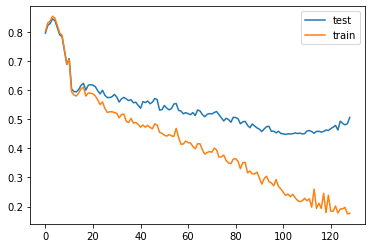

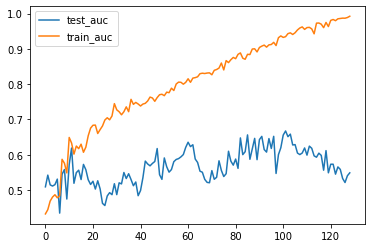

In [270]:
# visualize results
results=pd.DataFrame(loss_values)
results[["test","train"]].plot(),results[["test_auc","train_auc"]].plot(),

In [230]:
# results on test dataset, loss and AUC
best_model.eval() 
print(nogradmetrics(X_test,y_test,best_model,multi_segment=MULTI_SEGMENT))
print(nogradmetrics(X_val,y_val,best_model,multi_segment=MULTI_SEGMENT))

best_model=best_model.train()

(0.44687750935554504, 0.7438541243396993)
(0.40457794070243835, 0.762341633901267)


In [285]:
y_pred = best_model(XALL)

y_pred_10 =y_pred.reshape(-1,10,2)
indices=torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices
y_pred_10 = y_pred_10[range(y_pred_10.shape[0]),indices,:].reshape(-1,2)

y_test_10 = torch.max(y_trueALL.reshape(-1,10),dim=1).values

loss = criterion(y_pred_10, y_test_10)
y_test_10=y_test_10.cpu().detach().numpy()
# torch.exp(y_pred_10[:,1].cpu())
y_pred_10=torch.exp(y_pred_10[:,1]).cpu().detach().numpy()
train_auc=roc_auc_score(y_test_10,
                        y_pred_10) 

In [286]:
train_auc

0.8097363945578231

In [268]:
torch.exp(y_pred_10[:,1].cpu()),y_trueALL[:2]

(tensor([0.1898, 0.0020, 0.0172,  ..., 0.2798, 0.0657, 0.2020],
        grad_fn=<ExpBackward>),
 tensor([0, 0], device='cuda:0'))

In [269]:
y_pred_10=torch.exp(y_pred_10[:,1].cpu())

In [289]:
y_pred_10[y_pred_10>=0.5]=1
y_pred_10[y_pred_10<0.5]=0


In [303]:
fileNames=list(humanresults.keys())

In [307]:
y_test_10[y_test_10!=y_pred_10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

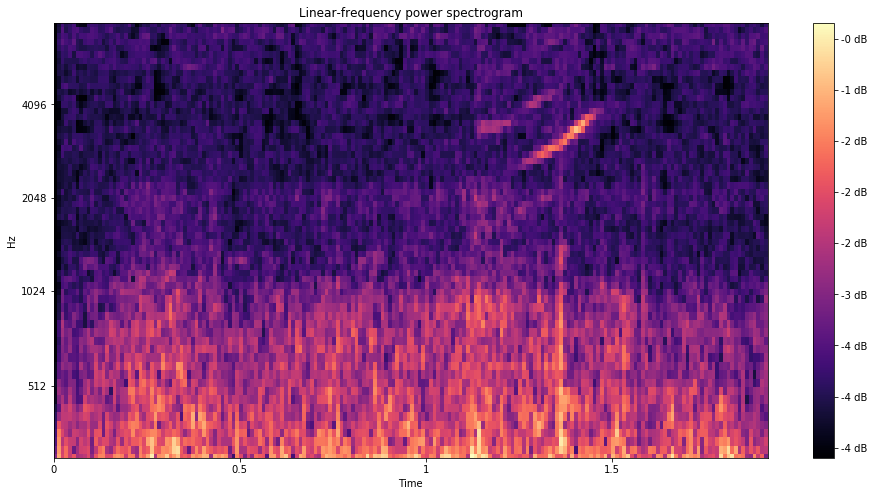

In [414]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))

# D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
# plt.subplot(4, 2, 1)
librosa.display.specshow(X[68,0:2,:,:].reshape(-1,64).T,y_axis="mel",x_axis="time",sr=16000,fmax=7500,fmin=125,hop_length=160)
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

In [402]:
new spectrum generate to see what happens 


(1300, 10, 96, 64)

In [236]:

items={}
from IPython.display import Audio,display,HTML,clear_output
from ipywidgets import Output

items["mp3_output"]=Output()

def play_html_modify(mp3file,items):
    out=items["mp3_output"]
    with out:
        clear_output()
    displayed=display(HTML("<audio autoplay controls loop src={} preload=\"auto\"> </audio>".format(mp3file)))


In [339]:
nextone=0


In [388]:
counter=0
srcPath="/files/scratch/enis/data/nna/labeling/splits/"
for i,b in enumerate(y_test_10!=y_pred_10):
    if b and y_test_10[i]==1:
        if counter==nextone:
            play_html_modify(srcPath+fileNames[i],items)
            print(srcPath+fileNames[i])
            print(i)
            break
        counter+=1
        
nextone+=1

/files/scratch/enis/data/nna/labeling/splits/CLVL4_20160617_033807_2074m_36s__2074m_46s.mp3
68


In [279]:
sum(y_trueALL)

tensor(1960, device='cuda:0')

In [243]:
best_model=best_model.eval()
y_predAll=best_model(XALL).reshape(-1,10,2)

In [247]:
y_trueALL[0],y_predAll[0]

(tensor(0, device='cuda:0'),
 tensor([-0.1779, -1.8142], device='cuda:0', grad_fn=<SelectBackward>))

In [ ]:
test_set=audioDataset(X_test,y_test)
test_generator = DataLoader(test_set, **params)


Following linse are for comparing sklearn MLP and this model

In [189]:
X_last=X[:]
# X_last=X_last.reshape(X_last.shape[0],-1)
X_last=X_last.reshape(-1,128)
X_last_sklearn=X_last[:]
X_last=torch.from_numpy(X_last).to(device)


In [ ]:
X_last.shape

In [190]:
y_pred_10.shape,y_test_10.shape

(torch.Size([1300, 2]), torch.Size([260]))

In [213]:
X_val.shape,y_val.shape

(torch.Size([2600, 128]), torch.Size([2600]))

In [214]:
best_model.eval()
with torch.no_grad():    
    
    y_pred = best_model(X_val)
    y_pred_10 =y_pred.reshape(-1,10,2)
    indices=torch.max(y_pred[:,1].reshape(-1,10),dim=1).indices
    y_pred_10 = y_pred_10[range(y_pred_10.shape[0]),indices,:].reshape(-1,2)

    y_val_10 = torch.max(y_val.reshape(-1,10),dim=1).values

#     loss = criterion(y_pred_10, y_true)

    train_auc=roc_auc_score(y_val_10.cpu().numpy(),
                            y_pred_10[:,1].cpu().numpy()) 
    print(train_auc)


0.8961980807266867


In [217]:
y_pred=y_pred_10.cpu()
y_pred=torch.exp(y_pred[:,1])
y_pred[y_pred>=0.5]=1
y_pred[y_pred<0.5]=0


In [220]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp=confusion_matrix(y_val_10.cpu().numpy(), y_pred).ravel()
tn, fp, fn, tp
(164, 23, 21, 52)
    sklearn  pytorch
tp   52       68
fp   23       67
tn   164      120
fn   21       5



(120, 67, 5, 68)

In [1]:
total=0
for i,mm in enumerate(y_true):
    predict= 1 if y_pred[i]>0.5 else 0 
    if mm!=predict:
        total+=1
        print(humanresults_keys[i])
print(total)

#### compare with sklearn

In [171]:
import pickle

# and later you can load it
with open('../Visualizations/raw_many2one_NN.pkl', 'rb') as f:
    clf = pickle.load(f)

In [172]:
def many2one_predict(X,clf):
    
    result_count=(X.shape[0]//10) if X.shape[0]%10==0 else (X.shape[0]//10)+1
    results=np.empty(result_count)
    for i in range(0,X.shape[0],10):
        result10=clf.predict(X[i:i+10,:])
        results[(i//10)] = np.max(result10)
    return results

In [196]:
X_last_sklearn.shape

(13000, 128)

In [205]:
#TEST
samples=np.ones((200,128))
y_pred_sklearn=many2one_predict(X_val.cpu().numpy(),clf['Neural Net_Songbird'])

In [221]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp=confusion_matrix(y_val_10.cpu().numpy(), y_pred_sklearn).ravel()
tn, fp, fn, tp

(164, 23, 21, 52)

In [203]:
total=0
for i,mm in enumerate(y_true):
    predict= 1 if y_pred[i]>0.5 else 0 
    predict_sklearn=int(y_pred_sklearn[i])
    if mm!=predict and mm==1:
        total+=1
        print(humanresults_keys[i],mm,predict,predict_sklearn)
print(total)

CLVL2_20160604_153809_1807m_40s__1807m_50s.mp3 1 0 0
CLVL5_20160606_195535_1100m_07s__1100m_17s.mp3 1 0 0
OCNPT_20160626_214658_0865m_02s__0865m_12s.mp3 1 0 0
USGS_20160618_030453_1287m_34s__1287m_44s.mp3 1 0 0
SHORTY_20160619_042858_2563m_41s__2563m_51s.mp3 1 0 0
OCNPT3_20160615_005046_0813m_58s__0814m_08s.mp3 1 0 0
FSHCK3_20160720_115157_1777m_41s__1777m_51s.mp3 1 0 0
UMIRUK_20160621_083400_0515m_46s__0515m_56s.mp3 1 0 0
FSHCK4_20160629_194935_0237m_49s__0237m_59s.mp3 1 0 0
ITKILLIK1_20160710_091444_0974m_18s__0974m_28s.mp3 1 0 0
CLVL2_20160715_134031_0935m_28s__0935m_38s.mp3 1 0 0
FSHCK3_20160706_000310_2407m_12s__2407m_22s.mp3 1 0 0
ITKILLIK2_20160626_172259_2184m_56s__2185m_06s.mp3 1 0 0
FSHCK1_20160808_050938_0344m_36s__0344m_46s.mp3 1 0 0
ICERD_20160824_161434_0373m_50s__0374m_00s.mp3 1 0 0
CLVL2_20160715_134031_2759m_40s__2759m_50s.mp3 1 0 0
USGS_20160609_201955_0289m_57s__0290m_07s.mp3 1 0 0
CLVL4_20160701_002747_2710m_53s__2711m_03s.mp3 1 0 0
UMIAT_20130727_224356_0077m_01s__

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred)

In [411]:
np.exp([-6.7866, -4.4634])
F.softmax(torch.Tensor([0.5403, 0.4597]),dim=0),torch.exp(F.log_softmax(torch.Tensor([ 0.1147, -0.0307]),dim=0))

(tensor([0.5201, 0.4799]), tensor([0.5363, 0.4637]))